In [497]:
import numpy as np
from sympy import *

from qiskit import *
from qiskit.quantum_info import *

from qiskit.circuit.library import *

from numpy.testing import assert_almost_equal as aae

import matplotlib.pyplot as plt
import matplotlib

In [125]:
mat_close = lambda A, B: np.all(np.isclose(A, B))

The $\gamma$ map is defined as $\gamma: u \mapsto u\sigma_y^{\otimes 2} u^T \sigma_y^{\otimes 2}$. Given a matrix $u \in SU(4)$, I found some pattern in the relationship between the trace of $\gamma(u)$ and the number of CNOT it uses. More specifically, let $\alpha = Tr(\gamma(u))$.

- $|\alpha| = 4 \implies$ 0 CNOT

- $|\alpha| = 0 \implies$ 1 CNOT

- $|\alpha| \text{ is real} \implies$ 2 CNOT

- $|\alpha| \text{ is complex} \implies$ 3 CNOT

Whether this implication is always true is in question. It's kinda late so I will probably prove this tomorrow.

In [294]:
def to_su(u): # Convert a matrix in U(4) to SU(4)
    u = u / np.sqrt(np.sqrt(np.linalg.det(u)))
    
    return u

def gamma_map(u): # Perform the gamma map above
    sigma_y = np.array([[0, -1j], 
                        [1j, 0]])
    
    return u@np.kron(sigma_y, sigma_y)@u.T@np.kron(sigma_y, sigma_y)

def classification(u, output_trace = False):
    
    u = to_su(u)
    
    mat_trace = np.round(np.trace(gamma_map(u)), 14)
    
    if output_trace:
        print(mat_trace)
    
    if (mat_trace == -4) or (mat_trace == 4):
        return 0
    elif mat_trace == 0:
        return 1
    elif np.isreal(mat_trace):
        return 2
    else:
        return 3

I check the classification for CNOT as two qubit gate.

In [286]:
cnot = np.array([[1, 0, 0, 0], 
                 [0, 1, 0, 0], 
                 [0, 0, 0, 1], 
                 [0, 0, 1, 0]])

for i in range(1000):

    MA = np.kron(random_unitary(2).data, random_unitary(2).data)
    MB = np.kron(random_unitary(2).data, random_unitary(2).data)
    MC = np.kron(random_unitary(2).data, random_unitary(2).data)
    MD = np.kron(random_unitary(2).data, random_unitary(2).data)

    M0 = MA
    M1 = M0@cnot@MB
    M2 = M1@cnot@MC
    M3 = M2@cnot@MD

    assert classification(M0) == 0, 'zero'
    assert classification(M1) == 1, 'one'
    assert classification(M2) == 2, 'two'
    assert classification(M3) == 3, 'three'

I did a little bit more digging and I found that it also works for $iSWAP$ gate.

In [300]:
isw = iSwapGate().to_matrix()

for i in range(1000):

    MA = np.kron(random_unitary(2).data, random_unitary(2).data)
    MB = np.kron(random_unitary(2).data, random_unitary(2).data)
    MC = np.kron(random_unitary(2).data, random_unitary(2).data)
    MD = np.kron(random_unitary(2).data, random_unitary(2).data)

    M0 = MA
    M1 = M0@isw@MB
    M2 = M1@isw@MC
    M3 = M2@isw@MD

    assert classification(M0) == 0, 'zero'
    assert classification(M1) == 1, 'one'
    assert classification(M2) == 2, 'two'
    assert classification(M3) == 3, 'three'

I look at the $\sqrt{iSWAP}$ as the native two qubit gates. Here, the classification changes a little. For 1 gate, the trace is 2. For 2 and 3, the trace is complex. This might have to do with the fact that two $\sqrt{iSWAP}$ gate makes up a 79% of the SU(4) gate.

In [391]:
sqisw = np.array([[1, 0, 0, 0],
                  [0, 1/np.sqrt(2), 1j/np.sqrt(2), 0], 
                  [0, 1j/np.sqrt(2), 1/np.sqrt(2), 0], 
                  [0, 0, 0, 1]])

MA = np.kron(random_unitary(2).data, random_unitary(2).data)
MB = np.kron(random_unitary(2).data, random_unitary(2).data)
MC = np.kron(random_unitary(2).data, random_unitary(2).data)
MD = np.kron(random_unitary(2).data, random_unitary(2).data)

M0 = MA
M1 = M0@sqisw@MB
M2 = M1@sqisw@MC
M3 = M2@sqisw@MD

classification(M0, True)
classification(M1, True)
classification(M2, True)
classification(M3, True)

(4-0j)
(2-0j)
(0.48837545892771-0.06166920422275j)
(0.91005464462747-0.03736227240537j)


3

I look at the values of that the trace covers for two and three $\sqrt{iSWAP}$ gates. The ration btw the two area looks alot like 79%.

In [619]:
trace_list1 = [] # Two sqiSW

sqisw = np.array([[1, 0, 0, 0],
                  [0, 1/np.sqrt(2), 1j/np.sqrt(2), 0], 
                  [0, 1j/np.sqrt(2), 1/np.sqrt(2), 0], 
                  [0, 0, 0, 1]])

for _ in range(10_000):

    MA = np.kron(random_unitary(2).data, random_unitary(2).data)
    MB = np.kron(random_unitary(2).data, random_unitary(2).data)
    MC = np.kron(random_unitary(2).data, random_unitary(2).data)

    M = MA@sqisw@MB@sqisw@MC

    M = to_su(M)

    mat_trace = np.trace(gamma_map(M))
    
    trace_list1.append(mat_trace)
    
    

trace_list2 = [] # Three sqiSW

for _ in range(10_000):

    MA = np.kron(random_unitary(2).data, random_unitary(2).data)
    MB = np.kron(random_unitary(2).data, random_unitary(2).data)
    MC = np.kron(random_unitary(2).data, random_unitary(2).data)
    MD = np.kron(random_unitary(2).data, random_unitary(2).data)
    
    M = MA@sqisw@MB@sqisw@MC@sqisw@MD

    M = to_su(M)

    mat_trace = np.trace(gamma_map(M))
    
    trace_list2.append(mat_trace)

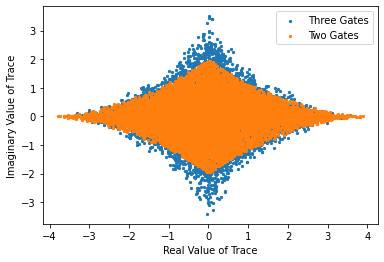

In [620]:
plt.xlabel('Real Value of Trace')
plt.ylabel('Imaginary Value of Trace')
plt.scatter(np.real(trace_list2), np.imag(trace_list2), s = 5)
plt.scatter(np.real(trace_list1), np.imag(trace_list1), s = 5)
plt.legend(['Three Gates', 'Two Gates'])

Here I plot the density of these points

In [626]:
no_bins = 100

Area covered by two gates: 10.072993343990344
Area covered by three gates: 12.98252247644171


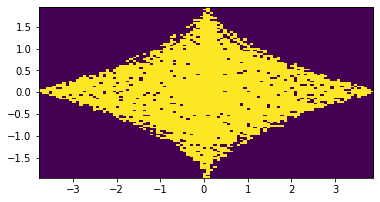

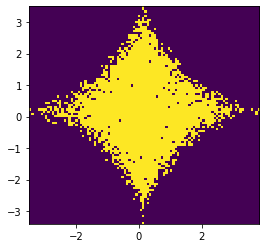

In [627]:
hist, xedges, yedges = np.histogram2d(np.real(trace_list1), np.imag(trace_list1), bins=no_bins)

over_threshold = hist > 0

fig = plt.figure()
s = fig.add_subplot(1, 1, 1)
s.imshow(
    over_threshold, interpolation='nearest',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap=matplotlib.cm.viridis)

area1 = over_threshold.sum() * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
print(f'Area covered by two gates: {area1}')

hist, xedges, yedges = np.histogram2d(np.real(trace_list2), np.imag(trace_list2), bins=no_bins)

over_threshold = hist > 0

fig = plt.figure()
s = fig.add_subplot(1, 1, 1)
s.imshow(
    over_threshold, interpolation='nearest',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap=matplotlib.cm.viridis)

area2 = over_threshold.sum() * (xedges[1] - xedges[0]) * (yedges[1] - yedges[0])
print(f'Area covered by three gates: {area2}')

If we take the ratio between the area covered by the trace of two $\sqrt{iSWAP}$ gates vs three, we get

In [628]:
print(f"Ratio: {area1/area2 * 100}%")

Ratio: 77.58887660136122%


For Ising $R_zz$ gate I find that one gate unitary also has a fixed trace

In [443]:
gate = RZZGate(np.pi/3).to_matrix()

MA = np.kron(random_unitary(2).data, random_unitary(2).data)
MB = np.kron(random_unitary(2).data, random_unitary(2).data)
MC = np.kron(random_unitary(2).data, random_unitary(2).data)
MD = np.kron(random_unitary(2).data, random_unitary(2).data)

M0 = MA
M1 = M0@gate@MB
M2 = M1@gate@MC
M3 = M2@gate@MD

classification(M0, True)
classification(M1, True)
classification(M2, True)
classification(M3, True)

(-4+0j)
(2+0j)
(1.97660081469+0j)
(1.9725233602174+0.44191162183823j)


3

We plot this fixed value with the angle theta.

In [412]:
trace_list = []

for theta in np.linspace(0, 2*np.pi, 100):

    MA = np.kron(random_unitary(2).data, random_unitary(2).data)
    MB = np.kron(random_unitary(2).data, random_unitary(2).data)

    gate = RZZGate(theta).to_matrix()

    M = MA@gate@MB

    M = to_su(M)

    mat_trace = np.abs(np.trace(gamma_map(M)))
    
    trace_list.append(mat_trace)

The graph looks alot like the concurrence value for different theta value.

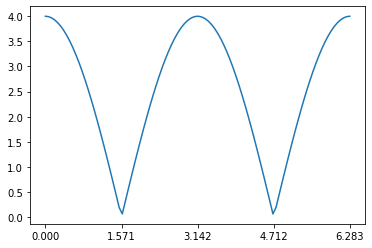

In [418]:
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
plt.plot(np.linspace(0, 2*np.pi, 100), trace_list)

For two gates, we can kinda still see the shape from above

In [451]:
trace_list = []

for theta in np.linspace(0, 2*np.pi, 100):

    MA = np.kron(random_unitary(2).data, random_unitary(2).data)
    MB = np.kron(random_unitary(2).data, random_unitary(2).data)
    MC = np.kron(random_unitary(2).data, random_unitary(2).data)
    
    gate = RZZGate(theta).to_matrix()

    M = MA@gate@MB@gate@MC

    M = to_su(M)

    mat_trace = np.abs(np.trace(gamma_map(M)))
    
    trace_list.append(mat_trace)

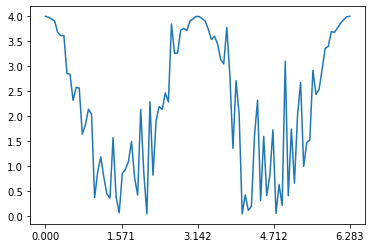

In [453]:
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
plt.plot(np.linspace(0, 2*np.pi, 100), trace_list)

In [490]:
trace_list = []

for theta in np.linspace(0, 2*np.pi, 100):

    MA = np.kron(random_unitary(2).data, random_unitary(2).data)
    MB = np.kron(random_unitary(2).data, random_unitary(2).data)
    MC = np.kron(random_unitary(2).data, random_unitary(2).data)
    MD = np.kron(random_unitary(2).data, random_unitary(2).data)


    gate = RZZGate(theta).to_matrix()

    M = MA@gate@MB@gate@MC@gate@MD

    M = to_su(M)

    mat_trace = np.abs(np.trace(gamma_map(M)))
    
    trace_list.append(mat_trace)

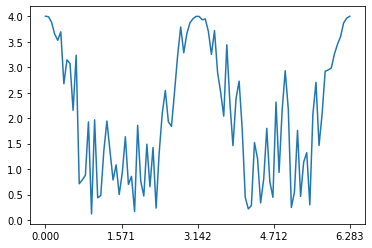

In [491]:
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
plt.plot(np.linspace(0, 2*np.pi, 100), trace_list)